In [1]:
# Import libraries
from bs4 import BeautifulSoup
import requests
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
r=requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')

In [3]:
r.status_code

200

In [4]:
soup = BeautifulSoup(r.text,'html.parser')

In [5]:
tbodys = soup.find('tbody')

In [6]:
#table header capture
header=tbodys.find_all('th')
header=[x.text.strip() for x in header]

In [7]:
rows = tbodys.find_all('tr')
table=[]
for row in rows[1:]:
    cols=row.find_all('td')
    cols=[x.text.strip() for x in cols]
    table.append(cols)


In [8]:
df=pd.DataFrame(table,columns=header)

* drop missing borough

In [9]:
df=df[~(df['Borough']=='Not assigned')] 

In [10]:
postcode=df.Postcode
borough=df.Borough
Neighbourhood=df.Neighbourhood

* Missing neighbourhood replaced by borough

In [11]:
for i in range(len(borough)):
    if Neighbourhood.iloc[i]=='Not assigned':
        Neighbourhood.iloc[i]=borough.iloc[i]

In [12]:
postcode=df.Postcode.tolist()
borough=df.Borough.tolist()
Neighbourhood=df.Neighbourhood.tolist()

* Neighbourhood list groupby postcode

In [13]:
new_table=[]
postcode_explored = [] # Initializing the list of explored postcodes
for index_i, postcode_i in enumerate(postcode) :   
    if postcode_i not in postcode_explored :
        nbds = Neighbourhood[index_i]
        for index_f, postcode_f in enumerate(postcode) :
            if postcode_i == postcode_f and index_i != index_f:
                nbds = nbds + ', ' + Neighbourhood[index_f] # Concatenating the neighbourhood names
        new_table.append([postcode_i, borough[index_i], nbds]) # Writing the rows in the csv file
        postcode_explored.append(postcode_i)

In [14]:
df=pd.DataFrame(new_table,columns=header)

In [15]:
df.shape

(103, 3)

# Latitude and Longitude

In [16]:
df1=pd.read_csv('https://cocl.us/Geospatial_data')

In [17]:
df1.rename(columns={'Postal Code':'Postcode'}, inplace=True)

In [18]:
lldf=df.merge(df1,on='Postcode')

In [19]:
lldf.shape

(103, 5)

In [20]:
lldf.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


In [21]:
lldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 0 to 102
Data columns (total 5 columns):
Postcode         103 non-null object
Borough          103 non-null object
Neighbourhood    103 non-null object
Latitude         103 non-null float64
Longitude        103 non-null float64
dtypes: float64(2), object(3)
memory usage: 4.8+ KB


# Clustering around TRT

In [22]:
# Matplotlib and associated plotting modules
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library


In [33]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[43.6532, -79.3832], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(lldf['Latitude'], lldf['Longitude'], lldf['Borough'], lldf['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

* Figure out the best k for K-means clustering by ploting elbow curve on F1 score

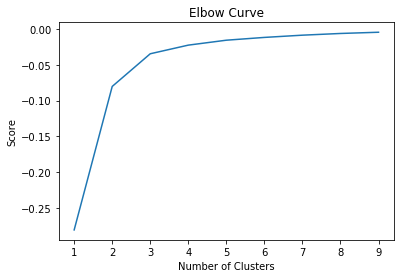

In [29]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = lldf[['Latitude']]
X_axis = lldf[['Longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

* Best F1 score achieved when k=3

In [30]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(lldf[['Latitude','Longitude']]) # Compute k-means clustering.
lldf['cluster_label'] = kmeans.fit_predict(lldf[['Latitude','Longitude']])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
lldf['labels'] = kmeans.predict(lldf[['Latitude','Longitude']]) # Labels of each point
lldf.head(10)

,Postcode,Borough,Neighbourhood,Latitude,Longitude,cluster_label,labels
0,M3A,North York,Parkwoods,43.753259,-79.329656,2,2
1,M4A,North York,Victoria Village,43.725882,-79.315572,2,2
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,0,0
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,1,1
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494,0,0
5,M9A,Downtown Toronto,Queen's Park,43.667856,-79.532242,1,1
6,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,2,2
7,M3B,North York,Don Mills North,43.745906,-79.352188,0,0
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937,2,2
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,0,0


In [35]:
# create map
map_clusters = folium.Map(location=[43.6532, -79.3832], zoom_start=11)

# set color scheme for the clusters
x = np.arange(3)
ys = [i+i*x+(i*x)**2 for i in range(3)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, post, bor, poi, cluster in zip(lldf['Latitude'], lldf['Longitude'], lldf['Postcode'], lldf['Borough'], lldf['Neighbourhood'], lldf['cluster_label']):
    label = folium.Popup('{} ({}): {} - Cluster {}'.format(bor, post, poi, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

* Observation: CLustering by coordinate resulting three clustered regions:
  * West and Central separated by Downview airport
  * Central region is crowed around the city airport
  * East is drawed by vertical and horizontal red express way